In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time


In [2]:
#data = pd.read_csv('C:\\Users\\kr015\\Documents\\Machine Learning\Meal Plan\\Final\\SampleData.csv')
data = pd.read_csv("../input/SampleData.csv")


In [3]:
data

,Ingredient,Product,QMerged_label,Real_Cost,V_0
0,1,1,11,10,0
1,1,2,12,6,0
2,2,1,21,8,0
3,2,2,22,11,0
4,3,1,31,3,0
5,3,2,32,7,0
6,4,1,41,8,0
7,4,2,42,5,0
8,4,3,43,1,0


In [4]:
def MCModelv1(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = 1  
        else:
            Return = -1 
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)




In [5]:
alpha = 0.1
num_episodes = 100
epsilon = 0.5
budget = 30

# Currently not using a reward
reward = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl = MCModelv1(data=data, alpha = alpha, e = num_episodes,epsilon = epsilon, budget = budget, reward = reward)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.8596932888031006 seconds ---


In [6]:
print(Mdl[3])

Mdl[4]


Ingredient
1    2
2    1
3    1
4    3
Name: Product, dtype: int64


,Ingredient,Product,QMerged_label,Real_Cost,V_0,V
0,1,1,11.0,10,0,0.159283
1,1,2,12.0,6,0,0.245423
2,2,1,21.0,8,0,0.248113
3,2,2,22.0,11,0,0.118510
4,3,1,31.0,3,0,0.249242
5,3,2,32.0,7,0,0.090192
6,4,1,41.0,8,0,0.122769
7,4,2,42.0,5,0,0.169190
8,4,3,43.0,1,0,0.249705


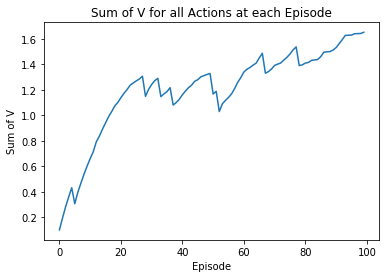

In [7]:
plt.plot(range(0,num_episodes), Mdl[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

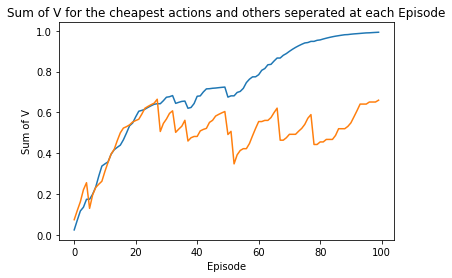

In [8]:
plt.plot(range(0,num_episodes), Mdl[1],range(0,num_episodes), Mdl[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


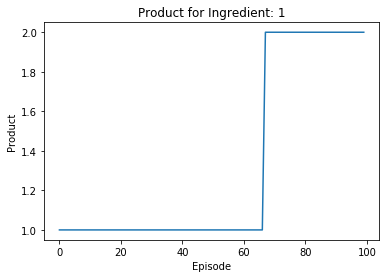

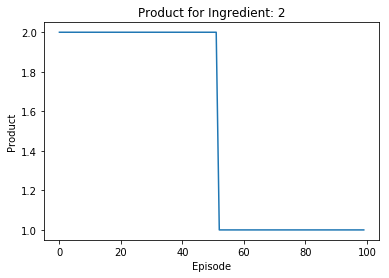

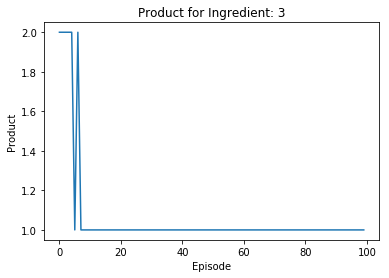

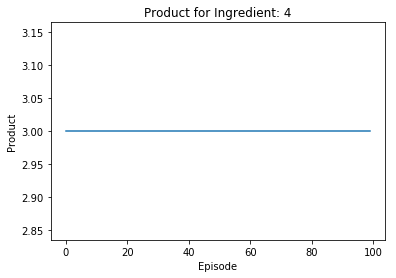

In [9]:
Ingredients = list(set(data['Ingredient']))
actions = pd.DataFrame()

for a in range(0, len(Ingredients)):   
    individualactions = []
    for i in range(0,num_episodes):    
        individualactions = np.append(individualactions, Mdl[5][a+(i*(len(Ingredients)))])
    actions[a] = individualactions
    plt.plot(range(0,num_episodes), actions[a])
    plt.title('Product for Ingredient: ' + str(a+1))
    plt.xlabel('Episode')
    plt.ylabel('Product')
    plt.show()    

    


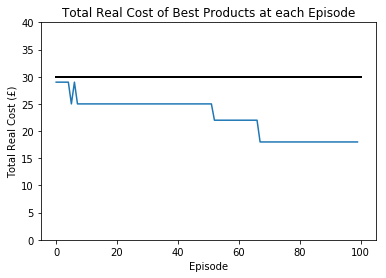

In [10]:
actions2 = actions
actions2['Product1'] = actions2.iloc[:,0]+10
actions2['Product2'] = actions2.iloc[:,1]+20
actions2['Product3'] = actions2.iloc[:,2]+30
actions2['Product4'] = actions2.iloc[:,3]+40

actions3 = actions2.merge(data[['QMerged_label','Real_Cost']],left_on = 'Product1',right_on = 'QMerged_label', how = 'left')
actions4 = actions3.merge(data[['QMerged_label','Real_Cost']],left_on = 'Product2',right_on = 'QMerged_label', how = 'left')
actions5 = actions4.merge(data[['QMerged_label','Real_Cost']],left_on = 'Product3',right_on = 'QMerged_label', how = 'left')
actions6 = actions5.merge(data[['QMerged_label','Real_Cost']],left_on = 'Product4',right_on = 'QMerged_label', how = 'left')


actions6['Total_Cost'] = actions6.iloc[:,9] + actions6.iloc[:,11] + actions6.iloc[:,13] + actions6.iloc[:,15]
actions6 = actions6.iloc[:,[0,1,2,3,-1]]

actions6 = actions6.iloc[:num_episodes]

plt.plot(range(0,num_episodes), actions6['Total_Cost'])
plt.plot([0, num_episodes], [budget, budget], 'k-', lw=2)
plt.title('Total Real Cost of Best Products at each Episode')
plt.xlabel('Episode')
plt.ylabel('Total Real Cost (£)')
plt.ylim([0,budget+10])
plt.show()

## Effect of Changing Parameters and How to Change Model's Aim



--- 2.8044843673706055 seconds ---


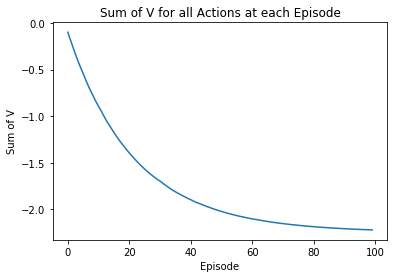

In [11]:
##### Make budget very small
budget2 = 5


alpha2 = 0.1
num_episodes2 = 100
epsilon2 = 0.5


# Currently not using a reward
reward2 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl2 = MCModelv1(data=data, alpha = alpha2, e = num_episodes2,epsilon = epsilon2, budget = budget2, reward = reward2)

print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(0,num_episodes2), Mdl2[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

--- 2.792497158050537 seconds ---


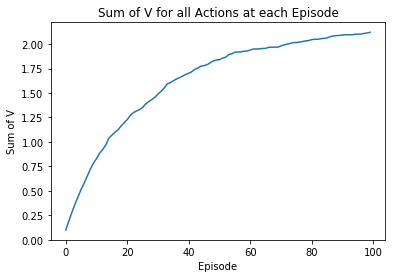

In [12]:
# Make budget very large
budget3 = 100


alpha3 = 0.1
num_episodes3 = 100
epsilon3 = 0.5


# Currently not using a reward
reward3 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl3 = MCModelv1(data=data, alpha = alpha3, e = num_episodes3,epsilon = epsilon3, budget = budget3, reward = reward3)

print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(0,num_episodes), Mdl3[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

--- 2.7898221015930176 seconds ---


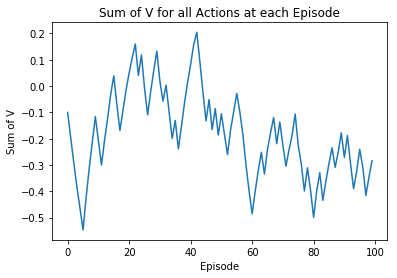

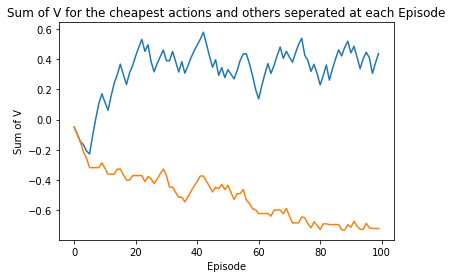

In [13]:
# Make budget reasonably small
budget4 = 23


alpha4 = 0.1
num_episodes4 = 100
epsilon4 = 0.5


# Currently not using a reward
reward4 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl4 = MCModelv1(data=data, alpha = alpha4, e = num_episodes4,epsilon = epsilon4, budget = budget4, reward = reward4)

print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(0,num_episodes4), Mdl4[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes4), Mdl4[1],range(0,num_episodes4), Mdl4[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

## Varying Alpha

In [14]:
from plotly.offline import init_notebook_mode, iplot, plot
from IPython.display import display, HTML
import plotly
import plotly.plotly as py
init_notebook_mode(connected=True)

In [15]:
# Provide all parameters fixed except alpha
budget5 = 23
num_episodes5 = 100
epsilon5 = 0.5

# Currently not using a reward
reward5 = [0,0,0,0,0,0,0,0,0]

VforInteractiveGraphA = []    
lA = []
num_episodes5_2 = []
for x in range(0, 10):
    alpha5 = 1 - x/10
    Mdl5 = MCModelv1(data=data, alpha = alpha5, e = num_episodes5,epsilon = epsilon5, budget = budget5, reward = reward5)
    VforInteractiveGraphA = np.append(VforInteractiveGraphA, Mdl5[0])
    for y in range(0, num_episodes5):
        lA = np.append(lA,alpha5)
        num_episodes5_2 = np.append(num_episodes5_2, y)
VforInteractiveGraphA2 = pd.DataFrame(VforInteractiveGraphA,lA)
VforInteractiveGraphA2['index1'] = VforInteractiveGraphA2.index
VforInteractiveGraphA2['Episode'] = num_episodes5_2
VforInteractiveGraphA2.columns = ['V', 'Alpha', 'Episode']
VforInteractiveGraphA2 = VforInteractiveGraphA2[['Alpha','Episode', 'V']]

VforInteractiveGraphA2.head()


,Alpha,Episode,V
1.0,1.0,0.0,-1.00
1.0,1.0,1.0,-1.50
1.0,1.0,2.0,-2.00
1.0,1.0,3.0,-2.00
1.0,1.0,4.0,-0.25


In [16]:
VforInteractiveGraphA3 = VforInteractiveGraphA2
VforInteractiveGraphA3['continent'] = 'Test'
VforInteractiveGraphA3['country'] = 'Test2'
VforInteractiveGraphA3['pop'] = 7000000.0
VforInteractiveGraphA3.columns = ['year', 'lifeExp', 'gdpPercap', 'continent', 'country', 'pop']

alphaforGraph = list(set(VforInteractiveGraphA3['year']))
alphaforGraph = np.round(alphaforGraph,1)
alphaforGraph = np.sort(alphaforGraph)[::-1]
years = np.round([(alphaforGraph) for alphaforGraph in alphaforGraph],1)
years

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

In [17]:
%matplotlib inline

dataset = VforInteractiveGraphA3

continents = []
for continent in dataset['continent']:
    if continent not in continents:
        continents.append(continent)
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['title'] = "Parameter Optimisation using Interactive Animation <br> PhilipOsborneData.com"
figure['layout']['xaxis'] = {'title': 'Episode'}
figure['layout']['yaxis'] = {'title': 'Sum of V', 'type': 'linear'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Alpha: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1.0
for continent in continents:
    dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

    data_dict = {
        'x': list(dataset_by_year_and_cont['lifeExp']),
        'y': list(dataset_by_year_and_cont['gdpPercap']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['country']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            'size': list(dataset_by_year_and_cont['pop'])
        },
        'name': continent
    }
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                'size': list(dataset_by_year_and_cont['pop'])
            },
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure['layout']['sliders'] = [sliders_dict]

iplot(figure)

In [18]:
# Provide all parameters fixed except alpha
budget6 = 23
num_episodes6 = 100
epsilon6 = 0.5

# Currently not using a reward
reward6 = [0,0,0,0,0,0,0,0,0]

VforInteractiveGraphA_2 = []    
lA2 = []
num_episodes6_2 = []
for x in range(0, 10):
    alpha6 = 0.1 - x/100
    Mdl6 = MCModelv1(data=data, alpha = alpha6, e = num_episodes6,epsilon = epsilon6, budget = budget6, reward = reward6)
    VforInteractiveGraphA_2 = np.append(VforInteractiveGraphA_2, Mdl6[0])
    for y in range(0, num_episodes6):
        lA2 = np.append(lA2,alpha6)
        num_episodes6_2 = np.append(num_episodes6_2, y)
VforInteractiveGraphA_22 = pd.DataFrame(VforInteractiveGraphA_2,lA2)
VforInteractiveGraphA_22['index1'] = VforInteractiveGraphA_22.index
VforInteractiveGraphA_22['Episode'] = num_episodes6_2
VforInteractiveGraphA_22.columns = ['V', 'Alpha', 'Episode']
VforInteractiveGraphA_22 = VforInteractiveGraphA_22[['Alpha','Episode', 'V']]


VforInteractiveGraphA_23 = VforInteractiveGraphA_22
VforInteractiveGraphA_23['continent'] = 'Test'
VforInteractiveGraphA_23['country'] = 'Test2'
VforInteractiveGraphA_23['pop'] = 7000000.0
VforInteractiveGraphA_23.columns = ['year', 'lifeExp', 'gdpPercap', 'continent', 'country', 'pop']

alphaforGraph2 = list(set(VforInteractiveGraphA_23['year']))
alphaforGraph2 = np.round(alphaforGraph2,2)
alphaforGraph2 = np.sort(alphaforGraph2)[::-1]
years = np.round([(alphaforGraph2) for alphaforGraph2 in alphaforGraph2],2)
years

%matplotlib inline

dataset = VforInteractiveGraphA_23

continents = []
for continent in dataset['continent']:
    if continent not in continents:
        continents.append(continent)
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['title'] = "Parameter Optimisation using Interactive Animation <br> PhilipOsborneData.com"
figure['layout']['xaxis'] = {'title': 'Episode'}
figure['layout']['yaxis'] = {'title': 'Sum of V', 'type': 'linear'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Alpha: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1.0
for continent in continents:
    dataset_by_year = dataset[np.round(dataset['year'],2) == np.round(year,2)]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

    data_dict = {
        'x': list(dataset_by_year_and_cont['lifeExp']),
        'y': list(dataset_by_year_and_cont['gdpPercap']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['country']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            'size': list(dataset_by_year_and_cont['pop'])
        },
        'name': continent
    }
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],2) == np.round(year,2)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                'size': list(dataset_by_year_and_cont['pop'])
            },
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure['layout']['sliders'] = [sliders_dict]

iplot(figure)


## Varying Epsilon

In [19]:
# Provide all parameters fixed except alpha
budget7 = 23
num_episodes7 = 100
alpha7  = 0.05

# Currently not using a reward
reward7 = [0,0,0,0,0,0,0,0,0]

VforInteractiveGraphA_3 = []    
lA3 = []
num_episodes7_3 = []
for x in range(0, 11):
    epsilon7 = 1 - x/10
    Mdl7 = MCModelv1(data=data, alpha = alpha7, e = num_episodes7,epsilon = epsilon7, budget = budget7, reward = reward7)
    VforInteractiveGraphA_3 = np.append(VforInteractiveGraphA_3, Mdl7[0])
    for y in range(0, num_episodes7):
        lA3 = np.append(lA3,epsilon7)
        num_episodes7_3 = np.append(num_episodes7_3, y)
VforInteractiveGraphA_32 = pd.DataFrame(VforInteractiveGraphA_3,lA3)
VforInteractiveGraphA_32['index1'] = VforInteractiveGraphA_32.index
VforInteractiveGraphA_32['Episode'] = num_episodes7_3
VforInteractiveGraphA_32.columns = ['V', 'Epsilon', 'Episode']
VforInteractiveGraphA_32 = VforInteractiveGraphA_32[['Epsilon','Episode', 'V']]


VforInteractiveGraphA_33 = VforInteractiveGraphA_32
VforInteractiveGraphA_33['continent'] = 'Test'
VforInteractiveGraphA_33['country'] = 'Test2'
VforInteractiveGraphA_33['pop'] = 7000000.0
VforInteractiveGraphA_33.columns = ['year', 'lifeExp', 'gdpPercap', 'continent', 'country', 'pop']

epsilonforGraph3 = list(set(VforInteractiveGraphA_33['year']))
epsilonforGraph3 = np.round(epsilonforGraph3,1)
epsilonforGraph3 = np.sort(epsilonforGraph3)[::-1]
years = np.round([(epsilonforGraph3) for epsilonforGraph3 in epsilonforGraph3],1)
years

%matplotlib inline

dataset = VforInteractiveGraphA_33

continents = []
for continent in dataset['continent']:
    if continent not in continents:
        continents.append(continent)
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['title'] = "Parameter Optimisation using Interactive Animation <br> PhilipOsborneData.com"
figure['layout']['xaxis'] = {'title': 'Episode'}
figure['layout']['yaxis'] = {'title': 'Sum of V', 'type': 'linear'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Epsilon: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1.0
for continent in continents:
    dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

    data_dict = {
        'x': list(dataset_by_year_and_cont['lifeExp']),
        'y': list(dataset_by_year_and_cont['gdpPercap']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['country']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            'size': list(dataset_by_year_and_cont['pop'])
        },
        'name': continent
    }
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for continent in continents:
        dataset_by_year = dataset[np.round(dataset['year'],1) == np.round(year,1)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['continent'] == continent]

        data_dict = {
            'x': list(dataset_by_year_and_cont['lifeExp']),
            'y': list(dataset_by_year_and_cont['gdpPercap']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['country']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                'size': list(dataset_by_year_and_cont['pop']),
                'color': 'rgba(255, 182, 193, .9)'
            },
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)


figure['layout']['sliders'] = [sliders_dict]

iplot(figure)


## Increasing the Number of Episodes

--- 31.505125522613525 seconds ---


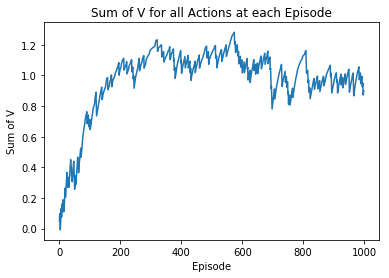

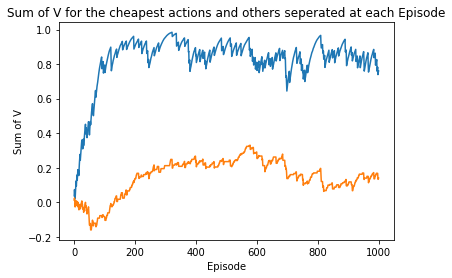

In [20]:
# Increase the number of episodes

budget8 = 23
alpha8 = 0.05
num_episodes8 = 1000
epsilon8 = 0.2

# Currently not using a reward
reward8 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl8 = MCModelv1(data=data, alpha = alpha8, e = num_episodes8,epsilon = epsilon8, budget = budget8, reward = reward8)

print("--- %s seconds ---" % (time.time() - start_time))


plt.plot(range(0,num_episodes8), Mdl8[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes8), Mdl8[1],range(0,num_episodes8), Mdl8[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

## Changing our Model's Aim to Find the Cheapest Combination of Products

#### This will now more clearly seperate the cheapest products from the rest and nearly always provides us with the cheapest combination of products.

In [21]:
def MCModelv2(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = (budget - episode2['Real_Cost'].sum())  
        else:
            Return = (budget - episode2['Real_Cost'].sum())
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)




--- 31.382521152496338 seconds ---
Ingredient
1    2
2    1
3    1
4    3
Name: Product, dtype: int64


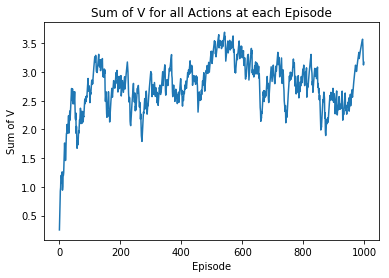

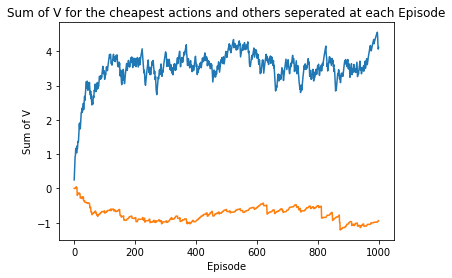

In [22]:
##### Make budget reasonably small
budget9 = 23


alpha9 = 0.05
num_episodes9 = 1000
epsilon9 = 0.2


# Currently not using a reward
reward9 = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl9 = MCModelv2(data=data, alpha = alpha9, e = num_episodes9,epsilon = epsilon9, budget = budget9, reward = reward9)

print("--- %s seconds ---" % (time.time() - start_time))

print(Mdl9[3])


plt.plot(range(0,num_episodes9), Mdl9[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes9), Mdl9[1],range(0,num_episodes9), Mdl9[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

# Introducing Preferences

In [23]:
def MCModelv3(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = 1 + (episode2['Reward'].sum())/(len(Ingredients))
        else:
            Return = -1 + (episode2['Reward'].sum())/(len(Ingredients))
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)




## Introducing Preferences using Rewards

--- 30.742338180541992 seconds ---
Ingredient
1    1
2    1
3    1
4    3
Name: Product, dtype: int64


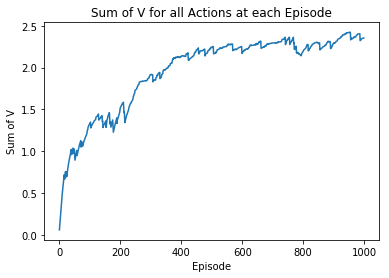

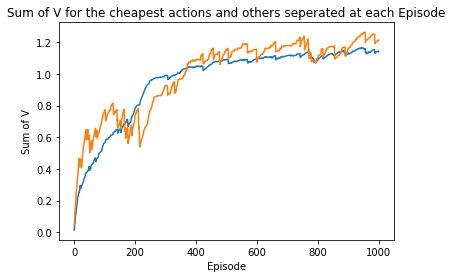

In [24]:
# Introduce simple rewards
budget10 = 30


alpha10 = 0.05
num_episodes10 = 1000
epsilon10 = 0.2


# Currently not using a reward
reward10 = [0.8,0,0,0.8,0,0,0,0,0]

start_time = time.time()

Mdl10 = MCModelv3(data=data, alpha = alpha10, e = num_episodes10,epsilon = epsilon10, budget = budget10, reward = reward10)

print("--- %s seconds ---" % (time.time() - start_time))

print(Mdl10[3])


plt.plot(range(0,num_episodes10), Mdl10[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes10), Mdl10[1],range(0,num_episodes10), Mdl10[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

--- 31.84322714805603 seconds ---
Ingredient
1    1
2    1
3    1
4    3
Name: Product, dtype: int64


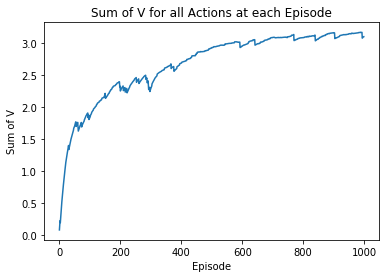

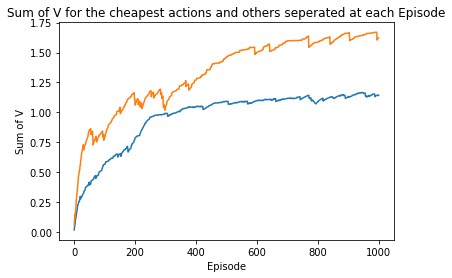

In [25]:
# Add rewards for more actions
budget11 = 30


alpha11 = 0.05
num_episodes11 = 1000
epsilon11 = 0.2


# Currently not using a reward
reward11 = [0.8,0.4,0.5,0.6,0.4,0.4,0.6,0.2,0.4]

start_time = time.time()

Mdl11 = MCModelv3(data=data, alpha = alpha11, e = num_episodes11,epsilon = epsilon11, budget = budget11, reward = reward11)

print("--- %s seconds ---" % (time.time() - start_time))

print(Mdl11[3])


plt.plot(range(0,num_episodes11), Mdl11[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()


plt.plot(range(0,num_episodes11), Mdl10[1],range(0,num_episodes11), Mdl11[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()